In [1]:
# Data generation
import json
import time
import math
import random
import statsmodels
import pandas as pd
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Settable parameters
timestamps_onemin = 4 * 7 * 24 * 60
timestamp_start_s = 1571608800
starting_hour = 8
end_hour = 20
room_capacity = 25
lesson_duration_hours = 2
lesson_duration_min = lesson_duration_hours * 60
arrival_and_exit_delay_min = 8
falloff_border = lesson_duration_min - arrival_and_exit_delay_min
arrival_and_exit_coef_min = room_capacity / arrival_and_exit_delay_min

# Function that models count of students in the room based on time of the day
def count_in_room(cur_val, coef, delay_val, capacity, falloff_val):
    cnt = capacity
    lb = -math.floor(0.1 * capacity)
    ub = math.ceil(0.1 * capacity)
    
    if cur_val <= delay_val:
        cnt = min(max(math.floor(coef * cur_val) + random.randrange(lb, ub, 1), 0), capacity)
    elif cur_val >= falloff_val:
        cnt = max(min(capacity, math.floor(capacity - coef * (cur_val - falloff_val)) + random.randrange(lb, ub, 1)), 0)
    # TODO: you can also model students going in and out of the room during the lesson
    
    return cnt

generated_ts = pd.DataFrame(columns = ['t', 'count'])

# Generating simulated students' count data - 
for i in range(timestamps_onemin):
    cur_timestamp_s = timestamp_start_s + i * 60
    cur_date = datetime.fromtimestamp(cur_timestamp_s)
    cur_wd = cur_date.weekday()
    cur_hour = cur_date.hour
    cur_min = cur_date.minute
    
    cnt_in_room = 0
    if (cur_wd < 5) & (cur_hour >= starting_hour) & (cur_hour <= end_hour):
        lessons_cur_min = (cur_hour * 60 + cur_min) % lesson_duration_min 
        cnt_in_room = count_in_room(lessons_cur_min, arrival_and_exit_coef_min, arrival_and_exit_delay_min, room_capacity, falloff_border)
    
    df_row = pd.DataFrame([[cur_date, cnt_in_room]], columns=['t', 'count'])
    generated_ts = generated_ts.append(df_row)
        
    # TODO: uncomment to check what is being generated    
    # print("%s : %d" % (cur_date , cnt_in_room))

generated_ts.index = generated_ts.t
print(generated_ts)

                                      t count
t                                            
2019-10-21 00:00:00 2019-10-21 00:00:00     0
2019-10-21 00:01:00 2019-10-21 00:01:00     0
2019-10-21 00:02:00 2019-10-21 00:02:00     0
2019-10-21 00:03:00 2019-10-21 00:03:00     0
2019-10-21 00:04:00 2019-10-21 00:04:00     0
...                                 ...   ...
2019-11-17 22:55:00 2019-11-17 22:55:00     0
2019-11-17 22:56:00 2019-11-17 22:56:00     0
2019-11-17 22:57:00 2019-11-17 22:57:00     0
2019-11-17 22:58:00 2019-11-17 22:58:00     0
2019-11-17 22:59:00 2019-11-17 22:59:00     0

[40320 rows x 2 columns]


In [3]:
# Data generation
import json
import time
import math
import random
import statsmodels
import pandas as pd
from datetime import datetime
import numpy as np
import tensorflow as tf
import os

                     SensorValues
TimeStamps                       
2022-05-23 16:08:21           0.0
2022-05-23 16:13:21           5.0
2022-05-23 16:18:21           5.0
2022-05-23 16:23:21           5.0
2022-05-23 16:28:21           5.0
...                           ...
2022-07-16 04:48:21           0.0
2022-07-16 04:53:21           0.0
2022-07-16 04:58:21           0.0
2022-07-16 05:03:21           0.0
2022-07-16 05:08:21           0.0

[15421 rows x 1 columns]


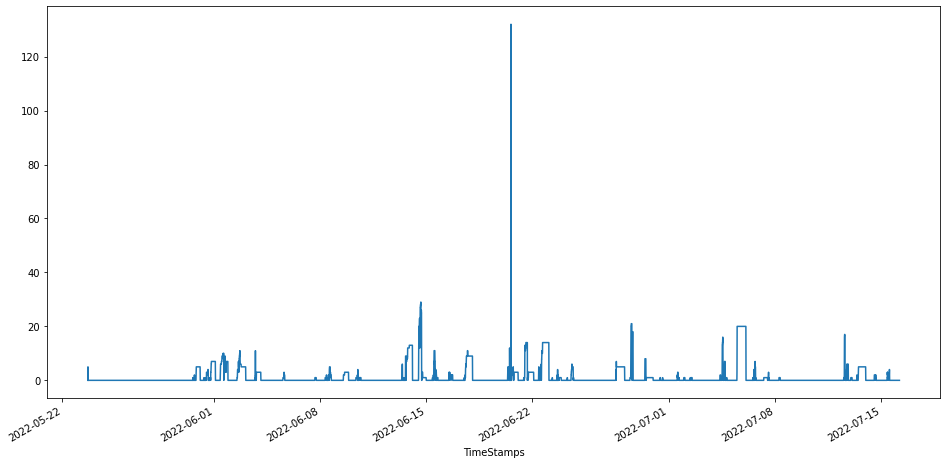

In [15]:
generated_ts=pd.read_csv(r'C:\Users\Alexandra Seibicke\Desktop\Praktikum\iot-lab\Predictions\correct.csv', index_col = 'TimeStamps', parse_dates=True)
#generated_ts=pd.read_csv(r'C:\Users\Alexandra Seibicke\Desktop\Mappe.csv', index_col = 'TimeStamps', parse_dates=True)
generated_ts = generated_ts[~generated_ts.index.duplicated(keep='first')]
generated_ts = generated_ts.asfreq('5T', method='pad')
generated_ts['SensorValues'].plot(figsize=(16,8))
temp = generated_ts['SensorValues']
print(generated_ts)

In [16]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X=[]
    y=[]
    for i in range(len(df_as_np)-window_size):
        row=[[a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)


In [17]:
WINDOW_SIZE = 3
X, y = df_to_X_y(temp, WINDOW_SIZE)
print(X)
print(X.shape)
X.shape, y.shape
print('X:', X[1])
print('y:', y)

[[[0.]
  [5.]
  [5.]]

 [[5.]
  [5.]
  [5.]]

 [[5.]
  [5.]
  [5.]]

 ...

 [[0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]]]
(15418, 3, 1)
X: [[5.]
 [5.]
 [5.]]
y: [5. 5. 0. ... 0. 0. 0.]


In [18]:
X_train, y_train = X[:7500], y[:7500]
X_val, y_val = X[7500:8350], y[7500:8350]
X_test, y_test = X[8350:], y[8350:]

In [21]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model = Sequential()
#model.add(InputLayer((3,1)))
#model.add(InputLayer((temp.size,1)))
model.add(LSTM(64))
model.add(Dense(8, 'relu'))
model.add(Dense(1, 'linear'))

# model.summary()

In [110]:
cp = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [111]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
222/235 [===========================>..] - ETA: 0s - loss: 0.9578 - root_mean_squared_error: 0.9787

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


235/235 [==============================] - 5s 15ms/step - loss: 0.9578 - root_mean_squared_error: 0.9787 - val_loss: 56.8928 - val_root_mean_squared_error: 7.5427
Epoch 2/10
218/235 [==========================>...] - ETA: 0s - loss: 0.8722 - root_mean_squared_error: 0.9339

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


235/235 [==============================] - 3s 14ms/step - loss: 0.8630 - root_mean_squared_error: 0.9290 - val_loss: 56.3208 - val_root_mean_squared_error: 7.5047
Epoch 3/10
229/235 [============================>.] - ETA: 0s - loss: 0.7643 - root_mean_squared_error: 0.8742

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


235/235 [==============================] - 3s 14ms/step - loss: 0.7893 - root_mean_squared_error: 0.8884 - val_loss: 55.7994 - val_root_mean_squared_error: 7.4699
Epoch 4/10
228/235 [============================>.] - ETA: 0s - loss: 0.7474 - root_mean_squared_error: 0.8645

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


235/235 [==============================] - 3s 15ms/step - loss: 0.7282 - root_mean_squared_error: 0.8533 - val_loss: 55.3786 - val_root_mean_squared_error: 7.4417
Epoch 5/10
234/235 [============================>.] - ETA: 0s - loss: 0.6753 - root_mean_squared_error: 0.8218

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


235/235 [==============================] - 4s 16ms/step - loss: 0.6743 - root_mean_squared_error: 0.8212 - val_loss: 55.0666 - val_root_mean_squared_error: 7.4207
Epoch 6/10
220/235 [===========================>..] - ETA: 0s - loss: 0.5983 - root_mean_squared_error: 0.7735

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


235/235 [==============================] - 3s 14ms/step - loss: 0.6294 - root_mean_squared_error: 0.7934 - val_loss: 54.7103 - val_root_mean_squared_error: 7.3966
Epoch 7/10
215/235 [==========================>...] - ETA: 0s - loss: 0.6244 - root_mean_squared_error: 0.7902

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


235/235 [==============================] - 3s 14ms/step - loss: 0.5912 - root_mean_squared_error: 0.7689 - val_loss: 54.4149 - val_root_mean_squared_error: 7.3766
Epoch 8/10
215/235 [==========================>...] - ETA: 0s - loss: 0.5487 - root_mean_squared_error: 0.7407

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


235/235 [==============================] - 3s 14ms/step - loss: 0.5579 - root_mean_squared_error: 0.7469 - val_loss: 54.1320 - val_root_mean_squared_error: 7.3574
Epoch 9/10
214/235 [==========================>...] - ETA: 0s - loss: 0.5106 - root_mean_squared_error: 0.7145

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


235/235 [==============================] - 4s 17ms/step - loss: 0.5295 - root_mean_squared_error: 0.7276 - val_loss: 53.8723 - val_root_mean_squared_error: 7.3398
Epoch 10/10
224/235 [===========================>..] - ETA: 0s - loss: 0.5026 - root_mean_squared_error: 0.7090

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


235/235 [==============================] - 3s 14ms/step - loss: 0.5027 - root_mean_squared_error: 0.7090 - val_loss: 53.6127 - val_root_mean_squared_error: 7.3221


In [112]:
from tensorflow.keras.models import load_model
model=load_model('model/')

In [113]:
train_predictions = model.predict(X_train).flatten()
train_results=pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

235/235 [==============================] - 1s 1ms/step


,Train Predictions,Actuals
0,7.076672,5.0
1,4.839847,5.0
2,4.839847,0.0
3,0.350386,0.0
4,-0.323138,0.0
...,...,...
7495,0.013577,0.0
7496,0.013577,0.0
7497,0.013577,0.0
7498,0.013577,0.0


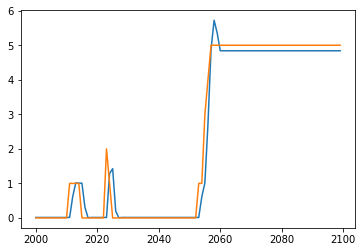

In [115]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][2000:2100])
plt.plot(train_results['Actuals'][2000:2100])

27/27 [==============================] - 0s 1ms/step


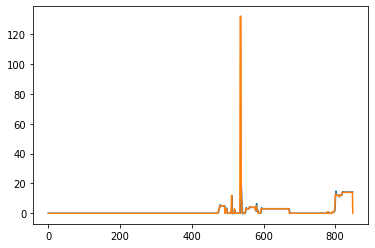

In [118]:
val_predictions = model.predict(X_val).flatten()
val_results=pd.DataFrame(data={'Train Predictions':val_predictions, 'Actuals':y_val})
plt.plot(val_results['Train Predictions'])
plt.plot(val_results['Actuals'])

151/151 [==============================] - 0s 1ms/step


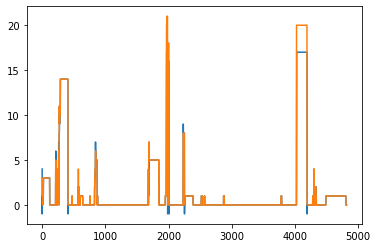

In [134]:
test_predictions = model.predict(X_test).flatten()
test_results=pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y_test})
plt.plot(test_results['Train Predictions'].round(decimals=0))
plt.plot(test_results['Actuals'])

In [120]:
# print(temp.shape)
# prediction=model.predict(temp).flatten
# print(prediction)

In [153]:
#print(X_test)
print('_________________')
lst = []
lst1 = []
lst2 = []
lst3 = []
#lst.append(X_test[-1].tolist())
lst1.append(5)
lst2.append(6)
# lst3.append(7)
lst.append(lst1)
lst.append(lst2)
# lst.append(lst3)
value = np.array(lst)
print('np array: \t', np.array(lst))
print ('value 1:', value[0][0])
print ('value 2:', value[1][0])
# print ('value 3:', value[2][0])

prediction_1 = model.predict(value).flatten()


print('prediction1:', prediction_1)
# value[0][0] = prediction_1
print('value:', prediction_1)

# prediction_1 = model.predict(value).flatten()
# prediction_1 = model.predict(value).flatten()
# print(test_predictions[-1])
#test_results=pd.DataFrame(data={'Test Predictions':test_predictions})
# plt.plot(test_predictions['Test Predictions'].round(decimals=0))
# plt.plot(test_results['Actuals'])

_________________
np array: 	 [[5]
 [6]]
value 1: 5
value 2: 6
1/1 [==============================] - 0s 15ms/step
prediction1: [2.8701909 3.361562 ]
value: [2.8701909 3.361562 ]


In [ ]:
from tensorflow.keras.models import load_model
model=load_model('model/')

In [26]:
WINDOW_SIZE = 3
X, y = df_to_X_y(temp, WINDOW_SIZE)
print(X)
print(X.shape)
X.shape, y.shape
print('X:', X[1])
print('y:', y)

[[[0]
  [0]
  [0]]

 [[0]
  [0]
  [0]]

 [[0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]]

 [[0]
  [0]
  [0]]

 [[0]
  [0]
  [0]]]
(436, 3, 1)
X: [[0]
 [0]
 [0]]
y: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 2 2 2 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 5 7 7 7 7 7 7 7 7 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 2 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 2 0 4 4 4 5 5 5 5 7 5 5 5 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 3 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 

14/14 [==============================] - 0s 1ms/step


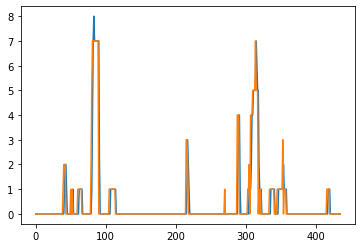

In [28]:
import matplotlib.pyplot as plt
test_predictions = model.predict(X).flatten()
test_results=pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y})
plt.plot(test_results['Train Predictions'].round(decimals=0))
plt.plot(test_results['Actuals'])

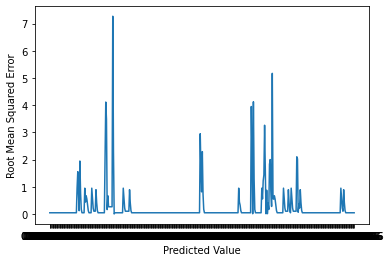

In [65]:

# example of increase in mean squared error
from matplotlib import pyplot
# from sklearn.metrics import mean_squared_error
# real value
expected = y
# predicted value
predicted = test_predictions
# calculate errors
errors = list()
for i in range(len(expected)):
	# calculate error
	err = (expected[i] - predicted[i])**2
	err = np.sqrt(err)
	# store error
	errors.append(err)
	# report error
	# print('>%.1f, %.1f = %.3f' % (expected[i], predicted[i], err))
# plot errors
pyplot.plot(errors)
pyplot.xticks(ticks=[i for i in range(len(errors))], labels=predicted)
pyplot.xlabel('Predicted Value')
pyplot.ylabel('Root Mean Squared Error')
pyplot.show()

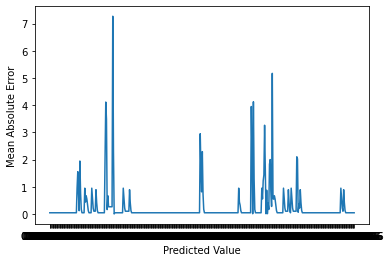

In [64]:
# example of increase in mean squared error
from matplotlib import pyplot
# from sklearn.metrics import mean_squared_error
# real value
expected = y
# predicted value
predicted = test_predictions
# calculate errors
errors = list()
for i in range(len(expected)):
	# calculate error
	#err = (expected[i] - predicted[i])**2
	err = abs((expected[i] - predicted[i]))
	# store error
	errors.append(err)
	# report error
	# print('>%.1f, %.1f = %.3f' % (expected[i], predicted[i], err))
# plot errors
pyplot.plot(errors)
pyplot.xticks(ticks=[i for i in range(len(errors))], labels=predicted)
pyplot.xlabel('Predicted Value')
pyplot.ylabel('Mean Absolute Error')
pyplot.show()

In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
#errors = mean_squared_error(expected, predicted, squared=True)
errors = mean_absolute_error(expected, predicted)
print(errors)

0.2625881669991607


In [73]:
def Average(lst):
    return sum(lst) / len(lst)

errors = list()
for i in range(len(expected)):
# calculate error
#err = (expected[i] - predicted[i])**2
    if expected[i]==0:
        err=0
    else:
        err = np.abs(expected[i]-predicted[i])/expected[i]*100
    errors.append(err)
print(Average(errors))



6.567478301943443


[[[1]
  [0]
  [1]]

 [[0]
  [1]
  [0]]

 [[1]
  [0]
  [1]]

 ...

 [[0]
  [1]
  [0]]

 [[1]
  [0]
  [1]]

 [[0]
  [1]
  [0]]]
(942, 3, 1)
X: [[0]
 [1]
 [0]]
y: [ 0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  1  0  1  0
  1  2  1  2  1  2  1  2  1  2  3  2  3  2  1  0  0  0  1  2  3  4  5  6
  7  8  9 10  9 10  9 10 11 10  9 10 11 12 13 14 13 12 11 10  9  8  7  6
  7  6  5  6  5  4  3  2  3  2  3  4  3  4  5  4  5  6  7  6  7  6  7  6
  7  8  9 10 11 12 13 12 11 10  9  8  7  6  5  6  5  6  5  4  3  2  1  0
  1  2  3  2  1  0  1  0  1  0  1  2  4  3  3  4  5  6  7  8 10  9 11 12
 13 14 15 16 17 18 19 20 19 20 21 22 23 24 25 26 27 26 25 24 23 22 21 20
 19 18 17 16 15 14 13 12 11 12 11 10  9  8  7  6  5  4  3  2  3  4  5  6
  7  6  7  8  9 10 11 12 13 14 15 16 15 16 17 18 19 18 19 18 17 16 15 14
 13 12 11 10  9  8  7  6  5  4  3  2  0  0  0  0  0  0  0  0  0  0  0  0
  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  1  0  1  0  0  0
  0  0  0  0  0  0  0  0  1  2  3  4 

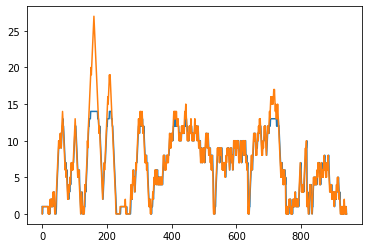

In [108]:
#reference['value'].plot(figsize=(16,8))
#generated_ts['SensorValues'].plot(figsize=(16,8))
generated_ts=pd.read_csv(r'C:\Users\Alexandra Seibicke\Desktop\Mappe4.csv', parse_dates=True, sep=';')
reference=pd.read_csv(r'C:\Users\Alexandra Seibicke\Desktop\new.csv', sep=';')

temp = reference['value']
WINDOW_SIZE = 3
X, y = df_to_X_y(temp, WINDOW_SIZE)
print(X)
print(X.shape)
X.shape, y.shape
print('X:', (X[1]))
print('y:', y)

import matplotlib.pyplot as plt
test_predictions = model.predict(X).flatten()
test_results=pd.DataFrame(data={'Train Predictions':test_predictions, 'Actuals':y})
plt.plot(test_results['Train Predictions'].round(decimals=0))
plt.plot(test_results['Actuals'])


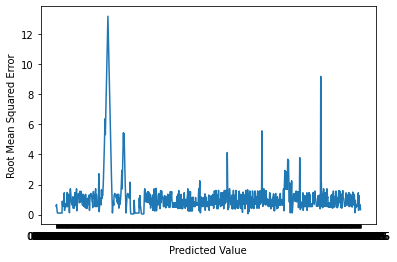

In [102]:

# example of increase in mean squared error
from matplotlib import pyplot
# from sklearn.metrics import mean_squared_error
# real value
expected = y
# predicted value
predicted = test_predictions
# calculate errors
errors = list()
for i in range(len(expected)):
	# calculate error
	err = (expected[i] - predicted[i])**2
	err = np.sqrt(err)
	# store error
	errors.append(err)
	# report error
	# print('>%.1f, %.1f = %.3f' % (expected[i], predicted[i], err))
# plot errors
pyplot.plot(errors)
pyplot.xticks(ticks=[i for i in range(len(errors))], labels=predicted)
pyplot.xlabel('Predicted Value')
pyplot.ylabel('Root Mean Squared Error')
pyplot.show()

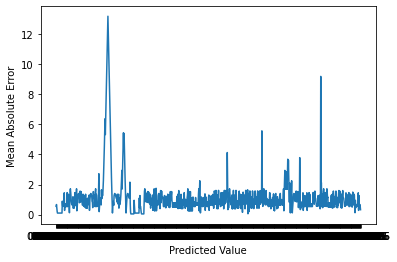

In [103]:
# example of increase in mean squared error
from matplotlib import pyplot
# from sklearn.metrics import mean_squared_error
# real value
expected = y
# predicted value
predicted = test_predictions
# calculate errors
errors = list()
for i in range(len(expected)):
	# calculate error
	#err = (expected[i] - predicted[i])**2
	err = abs((expected[i] - predicted[i]))
	# store error
	errors.append(err)
	# report error
	# print('>%.1f, %.1f = %.3f' % (expected[i], predicted[i], err))
# plot errors
pyplot.plot(errors)
pyplot.xticks(ticks=[i for i in range(len(errors))], labels=predicted)
pyplot.xlabel('Predicted Value')
pyplot.ylabel('Mean Absolute Error')
pyplot.show()

In [105]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
errors = mean_squared_error(expected, predicted, squared=True)
#errors = mean_absolute_error(expected, predicted)
print(errors)

3.096018124988663


In [106]:
def Average(lst):
    return sum(lst) / len(lst)

errors = list()
for i in range(len(expected)):
# calculate error
#err = (expected[i] - predicted[i])**2
    if expected[i]==0:
        err=0
    else:
        err = np.abs(expected[i]-predicted[i])/expected[i]*100
    errors.append(err)
print(Average(errors))

22.348138534716774
